In [1]:
import sys
sys.path.append("/home/emastr/moment-constrained-cryo-em/src/")

from single_degree_alignment import *
from geometry import *
from single_degree_plot import *
from single_degree_interpolation import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


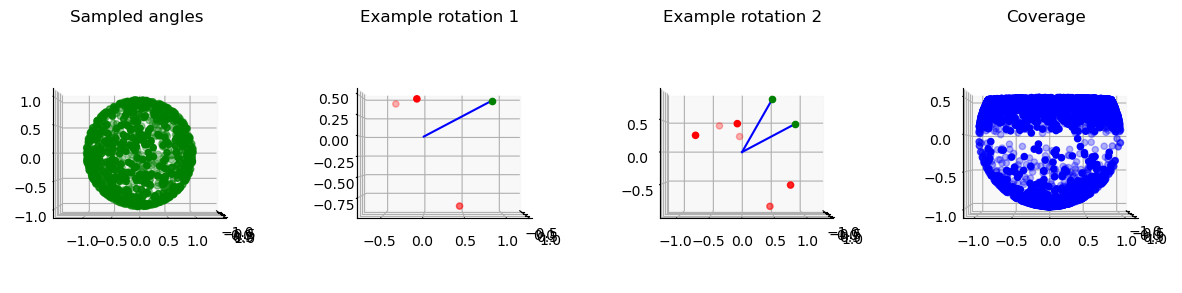

In [2]:
base_key = jax.random.PRNGKey(0)

# Indices
Lmax = 1
ls, ms = get_l_and_m(Lmax)
eval_shell_wrap = lambda thetas, phis, fm: eval_shell(thetas, phis, fm, ls, ms, Lmax)

# Interpolation grid
sampling_interp = "mw"
phis = s2fft.sampling.s2_samples.phis_equiang(Lmax+1, sampling_interp)
thetas = s2fft.sampling.s2_samples.thetas(Lmax+1, sampling_interp)
phis_grid, thetas_grid = jnp.meshgrid(phis, thetas, indexing="ij")

# Random signal
base_key, key = jax.random.split(base_key)
fm = random_signal(Lmax, key)

fm = fm.at[:Lmax - 1].set(0.)
fm = fm.at[Lmax+2:].set(0.)
#fm = 0*fm
#fm = fm.at[Lmax].set(1j)

f = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, Lmax), (0, None)), (None, 0))(thetas, phis)

def project(f):
    return f / jnp.linalg.norm(f) * jnp.linalg.norm(fm)

# Reference grid
#Alphas = phis_grid.flatten()
#Betas = thetas_grid.flatten() 
#Gammas = jnp.zeros_like(Alphas)

Ngrid = 1000
Alphas, Betas, _ = random_so3(key, Ngrid)
Gammas = jax.random.randint(key, (Ngrid,), 0, 2*Lmax) * 2 * jnp.pi / (2*Lmax + 1)
d_betas, sph_zero = get_slicing_weights(Betas, ms, Lmax)
fm_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas, d_betas, Gammas, ms, sph_zero)
f_rot_slices = vmap(sph_slice_to_vals, (0, None))(fm_rot_slices, Lmax)

# Random rotations
Nrots = 1000
base_key, key = jax.random.split(base_key)
Alphas_data, Betas_data, Gammas_data = random_so3(key, Nrots)
#rnd_idx = jax.random.randint(key, (Nrots,), 0, len(Alphas))
#gam_idx = jax.random.randint(key, (Nrots,), 0, 2*Lmax)
#Alphas_data = Alphas[rnd_idx]
#Betas_data = Betas[rnd_idx]
#Gammas_data = gam_idx * 2*jnp.pi / (2*Lmax + 1) #jnp.zeros_like(Alphas_data) #jax.random.uniform(key, (Nrots,))*2*jnp.pi

#Alphas_data = Alphas_data.at[:Ngrid].set(Alphas)
#Betas_data = Betas_data.at[:Ngrid].set(Betas)
#Gammas_data = Gammas_data.at[:Ngrid].set(Gammas)

d_betas_data, sph_zero = get_slicing_weights(Betas_data, ms, Lmax)
fm_rot_slices_data = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas_data, d_betas_data, Gammas_data, ms, sph_zero)
f_rot_slices_data = vmap(sph_slice_to_vals, (0, None))(fm_rot_slices_data, Lmax)

plot_rot(Alphas, Betas, Gammas, (2*Lmax+1))

In [3]:
f_rot_slices_est = align_data_to_slices_average(fm_rot_slices, f_rot_slices_data, fm_rot_slices_data)
fm_rot_slices_est = vmap(sph_vals_to_slice, (0, None))(f_rot_slices_est, Lmax)
lsq_solve, matvec = precompute_lsq(Alphas, Betas, Gammas, ms, Lmax)
print(f"Error between aligned data and true slices: {jnp.linalg.norm(fm_rot_slices_est - fm_rot_slices)}")
print(f"Error between true signal and lsq signal: {jnp.linalg.norm(lsq_solve(f_rot_slices_est.reshape(-1)) - fm)}")

Error between aligned data and true slices: nan
Error between true signal and lsq signal: nan


Error between true signal and lsq signal: 5.720940297473109
Error: 5.721084340533394, residual: 37.11651870324368, step=0.1
Error: 5.719078522292931, residual: 37.022834421561285, step=0.1
Error: 5.718340375008739, residual: 37.326577114336466, step=0.1
Error: 5.718320059533037, residual: 37.452992428229344, step=0.1
Error: 5.718296958135271, residual: 37.593114354618514, step=0.1
Error: 5.718318511570973, residual: 37.45299209137219, step=0.1
Error: 5.718316447624052, residual: 37.55294381858853, step=0.1
Error: 5.718327950880646, residual: 37.49404387972291, step=0.1
Error: 5.718311207459821, residual: 37.54017936348924, step=0.1
Error: 5.7183118410663, residual: 37.54017995966153, step=0.1


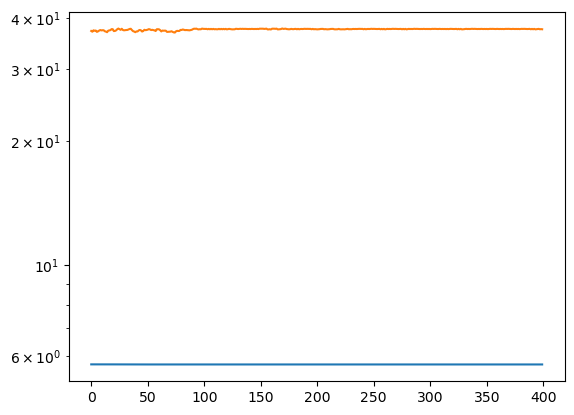

In [4]:
ratio = 0.
fm0 = random_signal(Lmax, jax.random.PRNGKey(125)) * (1-ratio) + fm/jnp.linalg.norm(fm)*ratio
fm0 = project(fm0)

print(f"Error between true signal and lsq signal: {jnp.linalg.norm(fm0 - fm)}")
    
def line_search(x, y, loss_fcn, step0=1.0):
    step = step0
    loss_x = loss_fcn(x)
    for i in range(10):
        x_new = (1-step)*x + step*y
        if loss_fcn(x_new) < loss_x:
            #print(f"step: {step}")
            return x_new, step
        step *= 0.5
    print("Warning: Line search failed")
    return x_new, step


def loss(fm_est):
    fm_rot_slices_est = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm_est, Alphas, d_betas, Gammas, ms, sph_zero)
    f_rot_slices_est = align_data_to_slices_average(fm_rot_slices_est, f_rot_slices_data, fm_rot_slices_data)
    f_rot_slices_est = jnp.where(jnp.isnan(f_rot_slices_est), 0, f_rot_slices_est)
    fm_est = fm_est * jnp.linalg.norm(fm) / jnp.linalg.norm(fm_est)
    return jnp.linalg.norm(matvec(fm_est) - f_rot_slices_est.reshape(-1))

ds = 0.01
step = 0.1
batch_size = None
Nsteps = 400
res_list = []
err_list = []

for i in range(Nsteps):
    fm0_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm0, Alphas, d_betas, Gammas, ms, sph_zero)
    
    if batch_size is not None:
        key, subkey = jax.random.split(key)
        batch_idx = jax.random.randint(subkey, (batch_size,), 0, Nrots)
        f_rot_slices_data_batch = f_rot_slices_data[batch_idx]
        fm_rot_slices_data_batch = fm_rot_slices_data[batch_idx]
        f0_rot_slices_est = align_data_to_slices_average(fm0_rot_slices, f_rot_slices_data_batch, fm_rot_slices_data_batch)
    else:    
        f0_rot_slices_est = align_data_to_slices_average(fm0_rot_slices, f_rot_slices_data, fm_rot_slices_data)
        
    f0_rot_slices_est = jnp.where(jnp.isnan(f0_rot_slices_est), 0, f0_rot_slices_est)
    fm0_rot_slices_est = vmap(sph_vals_to_slice, (0, None))(f0_rot_slices_est, Lmax)
    dfm0 = lsq_solve(f0_rot_slices_est.reshape(-1))
    #fm0, step  = line_search(fm0, dfm0, loss, step0=step)
    fm0 = (1 - ds) * fm0 + ds * dfm0
    fm0 = project(fm0)
    
    err = jnp.linalg.norm(fm0 - fm)
    res = loss(fm0)
    err_list.append(err)
    res_list.append(res)
    if i % (Nsteps//10) == 0:
        print(f"Error: {err}, residual: {res}, step={step}")#, end="\r")
        
plt.semilogy(err_list)
plt.semilogy(res_list)

In [5]:
def loss(fm_est):
    fm_rot_slices_est = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm_est, Alphas, d_betas, Gammas, ms, sph_zero)
    f_rot_slices_est = align_data_to_slices_average(fm_rot_slices_est, f_rot_slices_data, fm_rot_slices_data)
    f_rot_slices_est = jnp.where(jnp.isnan(f_rot_slices_est), 0, f_rot_slices_est)
    fm_est = fm_est * jnp.linalg.norm(fm) / jnp.linalg.norm(fm_est)
    return jnp.linalg.norm(matvec(fm_est) - f_rot_slices_est.reshape(-1))


thetas = jnp.linspace(0, jnp.pi, 50)
phis = jnp.linspace(0, 2*jnp.pi, 50)
thetas, phis = jnp.meshgrid(thetas, phis, indexing="ij")
(x, y, z) = sph2cart(thetas.flatten(), phis.flatten(), r=jnp.linalg.norm(fm))



fm_mat = 1j * jnp.array([x, y, z]).T
def pad(fm):
    return jnp.concatenate([jnp.zeros((len(fm), Lmax-1)), fm, jnp.zeros((len(fm), Lmax-1))], axis=1)
fm_mat = pad(fm_mat)

losses = vmap(loss)(fm_mat)
print(jnp.max(losses), jnp.min(losses), loss(fm))
def colormap(x,y,z,values):
    weights = (values - jnp.min(values))/(jnp.max(values) - jnp.min(values))
    colors = jnp.array([1, 0, 0]) * weights[:,None] + jnp.array([0, 0, 1]) * (1-weights[:, None])
    #colors = jnp.where(jnp.linalg.norm(jnp.array([x,y,z])-fm.imag)<0.1, jnp.zeros_like(colors), colors)
    return colors


#plt.figure()
#plt.scatter(thetas.flatten(), phis.flatten(), c=colormap(x,y,z,losses))



50.58678343596457 34.436982654328624 37.12340490433042


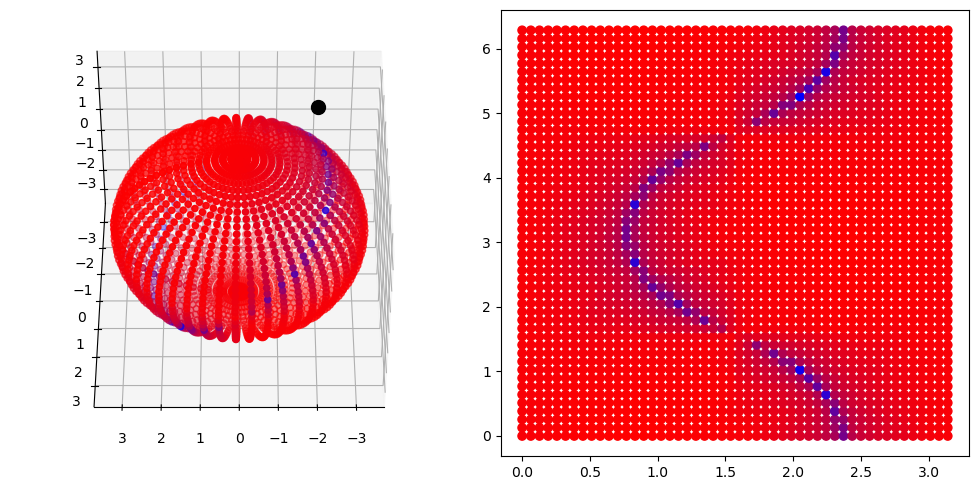

In [6]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121, projection='3d')
ax.scatter(x, y, z, color=colormap(x,y,z,losses))
ax.scatter(*fm[Lmax-1:Lmax+2].imag*1.4, s=100, color="black")
ax.view_init(elev=45, azim=90)

plt.subplot(122)
plt.scatter(thetas.flatten(), phis.flatten(), c=colormap(x,y,z,losses))

plt.tight_layout()


